# Description of the Purpose
The purpose of this notebook is to develop software that can simulate a range of driver behaviors on a spectrum from non-aggressive to aggressive. The software should be able to accept input parameters for speed limits over time (high and low limits), calculate a driver's speed according to these limits and a configurable level of driver aggressiveness, and potentially, relate the speed and aggressiveness level to energy consumption for the vehicle being simulated.

# Import Required Libraries
Import the necessary libraries, including pandas for data manipulation.

In [16]:
# Importing pandas library for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and Display Data
Load the data from the CSV file located at 'C:\MEIN_PLATZ\Git\vehicle-testing-project\data\AI_DRIVER___WLTC.csv' and display the first 4 lines of the dataframe.

In [17]:

data_path = r'C:\MEIN_PLATZ\Git\vehicle-testing-project\data\AI_DRIVER___WLTC.csv'
df = pd.read_csv(data_path, sep=';')
df.head(4)

C:\Users\43664\AppData\Local\Temp\ipykernel_1536\3306498356.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep=';')


,recorder_time,SPEED_LOW_TOL,SPEED_UP_TOL,D_SPEED_ArtDriver_0,D_SPEED_ArtDriver_2,D_SPEED_ArtDriver_4,D_SPEED_ArtDriver_6,D_SPEED_ArtDriver_8,D_SPEED_ArtDriver_10,D_SPEED_ArtDriver_12,...,WORK_ArtDriver_84,WORK_ArtDriver_86,WORK_ArtDriver_88,WORK_ArtDriver_90,WORK_ArtDriver_92,WORK_ArtDriver_94,WORK_ArtDriver_96,WORK_ArtDriver_98,WORK_ArtDriver_100,Unnamed: 105
0,s,km/h,km/h,km/h,km/h,km/h,km/h,km/h,km/h,km/h,...,J,J,J,J,J,J,J,J,J,NaN
1,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.1,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.2,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


# Data Exploration
Explore the data to understand its structure and the information it contains. This will help in the development of the simulation software.

In [30]:
if 1 in df.index:
    df = df.drop(1, axis=0)


In [31]:
# Drop the column 'unnamed:'
if 'unnamed: 105' in df:
    df = df.drop('Unnamed: 105', axis=1)

#df = df.astype(float)
print("\nStatistical summary")
print(df.describe())


Statistical summary
       recorder_time SPEED_LOW_TOL SPEED_UP_TOL D_SPEED_ArtDriver_0  \
count          18000         18000        18000               18000   
unique         18000          1899         1942                1917   
top              0.1          0.00         0.00                 0.0   
freq               1          1850         1444                1068   

       D_SPEED_ArtDriver_2 D_SPEED_ArtDriver_4 D_SPEED_ArtDriver_6  \
count                18000               18000               18000   
unique                1923                1921                1930   
top                    0.0                 0.0                 0.0   
freq                  1426                1069                1074   

       D_SPEED_ArtDriver_8 D_SPEED_ArtDriver_10 D_SPEED_ArtDriver_12  ...  \
count                18000                18000                18000  ...   
unique                1933                 1927                 1930  ...   
top                    0.0               

In [32]:
# Convert the columns in dataframe to float
df = df.astype(float)

<Axes: xlabel='recorder_time'>

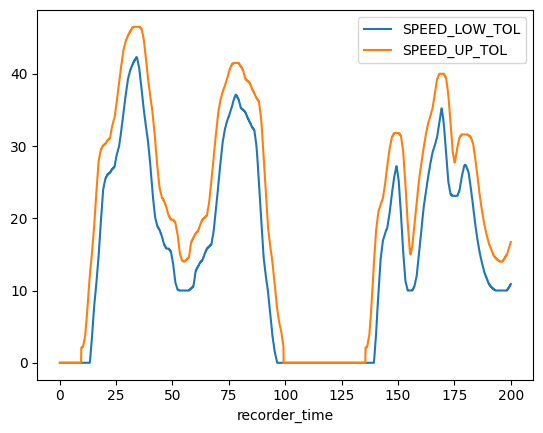

In [36]:
import numpy as np
df.head(2000).plot(x='recorder_time', y=['SPEED_LOW_TOL', 'SPEED_UP_TOL'])

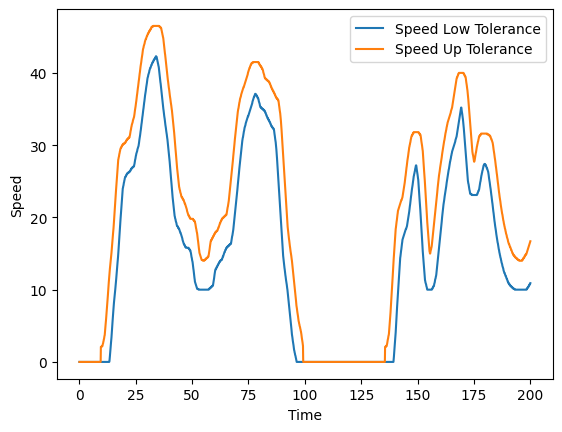

In [38]:
recorder_time_array = df['recorder_time'].values[:2000]
speed_low_tol_array = df['SPEED_LOW_TOL'].values[:2000]
speed_up_tol_array = df['SPEED_UP_TOL'].values[:2000]

plt.plot(recorder_time_array, speed_low_tol_array, label='Speed Low Tolerance')
plt.plot(recorder_time_array, speed_up_tol_array, label='Speed Up Tolerance')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()

In [41]:
aggressiveness = 0.5

def simulate_driver_behavior(speed_limits_low, speed_limits_high, aggressiveness):
    # Generate random speed values within the speed limits
    speed_values = np.random.uniform(speed_limits_low, speed_limits_high)
    
    # Adjust speed values based on driver aggressiveness
    adjusted_speed_values = speed_values * aggressiveness
    
    return adjusted_speed_values

driver_speed = simulate_driver_behavior(speed_low_tol_array, speed_up_tol_array, aggressiveness)


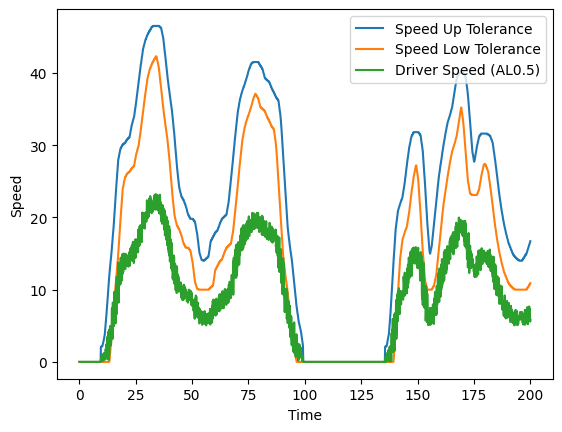

In [42]:
plt.plot(recorder_time_array, speed_up_tol_array, label='Speed Up Tolerance')
plt.plot(recorder_time_array, speed_low_tol_array, label='Speed Low Tolerance')
plt.plot(recorder_time_array, driver_speed, label=f'Driver Speed (AL{aggressiveness})')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()